In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, time, random, os, sys
from bs4 import BeautifulSoup
import requests
from SPARQLWrapper import SPARQLWrapper, JSON
from sklearn.decomposition import PCA

In [3]:
from SPARQLWrapper import CSV

# iNaturalist Observations
- Working on iNaturalist Observations
- We will put some filters to increase quality of the data
- Let's see how it goes
- Let's see how it works

In [6]:
df_iNat = pd.read_csv('/Users/devendragovil/Library/Application Support/inaturalist/observations.csv', parse_dates=True,sep='\t', usecols=[2,3,5,6,7])

In [7]:
df_iNat.head(10)

,latitude,longitude,taxon_id,quality_grade,observed_on
0,38.609740,-122.767302,53137.0,research,2011-05-30
1,41.007900,-95.897141,47157.0,needs_id,2011-06-02
2,NaN,NaN,54964.0,casual,2011-06-02
3,41.007900,-95.897141,358161.0,needs_id,2011-06-02
4,-25.719343,27.187214,2334.0,research,2007-06-27
5,63.573728,-148.946523,979757.0,research,2011-05-22
6,59.235833,-135.445000,5305.0,research,2011-04-26
7,63.588753,-154.493062,143688.0,research,2011-05-31
8,63.051847,-151.163775,1096645.0,research,2011-06-01
9,-2.428624,-59.764252,32455.0,research,2003-07-05


In [8]:
df_iNat.shape

(94765503, 5)

Note: Total observations are 94.765 million without any filters

In [9]:
df_iNat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94765503 entries, 0 to 94765502
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   latitude       float64
 1   longitude      float64
 2   taxon_id       float64
 3   quality_grade  object 
 4   observed_on    object 
dtypes: float64(3), object(2)
memory usage: 3.5+ GB


In [10]:
df_iNat_filtered = df_iNat[
    (df_iNat['latitude']>=36.4701132878)
    &
    (df_iNat['latitude']<=42.009518)
    &
    (df_iNat['longitude']>= -124.409591)
    &
    (df_iNat['longitude']<= -114.131211)
].copy()

In [11]:
df_iNat_filtered.shape

(4662891, 5)

Filtering by the bounding box for location reduces total obs to:
4.66 million

In [12]:
df_iNat_filtered['quality_grade'].value_counts()

research    2893582
needs_id    1588194
casual       181115
Name: quality_grade, dtype: int64

In [13]:
df_iNat_filtered = df_iNat_filtered[
    df_iNat_filtered['quality_grade'] == 'research'
].copy()

In [14]:
df_iNat_filtered.shape

(2893582, 5)

Filtering for research reduces to 2.893 million

In [21]:
df_iNat_filtered['observed_on_dt'] = pd.to_datetime(df_iNat_filtered['observed_on'])

In [23]:
df_iNat_filtered['observed_on_year'] = df_iNat_filtered['observed_on_dt'].dt.year
df_iNat_filtered['observed_on_mon'] = df_iNat_filtered['observed_on_dt'].dt.month

In [24]:
del(df_iNat)

Deleting df_iNat to save space above

In [26]:
df_iNat_filtered = df_iNat_filtered[
    df_iNat_filtered['observed_on_year'] == 2019
].copy()

In [27]:
df_iNat_filtered.shape

(352648, 8)

To Note: After year filter, futher reduces to 352 thousands

In [29]:
df_iNat_filtered['taxon_id'].nunique()

10804

In [34]:
df_species_to_pick = df_iNat_filtered.groupby('taxon_id').count().copy()

In [35]:
df_species_to_pick.reset_index(inplace=True)

In [37]:
df_species_to_pick['counts'] = df_species_to_pick['observed_on'].copy()

In [39]:
df_species_to_pick = df_species_to_pick[['taxon_id', 'counts']].copy()

In [42]:
df_species_to_pick.describe()

,taxon_id,counts
count,1.080400e+04,10804.000000
mean,2.294000e+05,32.640504
std,2.849076e+05,125.347509
min,1.620000e+02,1.000000
25%,6.073475e+04,1.000000
50%,8.078500e+04,4.000000
75%,3.207230e+05,16.000000
max,1.459288e+06,6020.000000


In [54]:
df_species_to_pick = df_species_to_pick[
    df_species_to_pick['counts']>=100
].copy()

In [55]:
df_species_to_pick

,taxon_id,counts
3,473.0,986
7,906.0,1329
16,1409.0,595
19,2548.0,249
20,2969.0,222
...,...,...
10638,1289388.0,477
10639,1289605.0,173
10640,1289607.0,325
10705,1392222.0,112


In [56]:
taxon_to_pick = set(df_species_to_pick['taxon_id'].values)

In [57]:
df_iNat_filtered = df_iNat_filtered[
    df_iNat_filtered['taxon_id'].apply(lambda x: True if x in taxon_to_pick else False)
].copy()

In [58]:
df_iNat_filtered.shape

(244202, 8)

In [60]:
df_iNat_filtered['observed_on_mon'].value_counts()

4     41106
5     27045
6     25766
3     23092
7     20870
8     17659
9     17181
10    16224
12    14610
1     14577
11    13777
2     12295
Name: observed_on_mon, dtype: int64

# Extracting the data for all taxons

In [65]:
# The template for the code below is taken from an example
#  in Wikidata examples from wikidata query service
endpoint_url = "https://query.wikidata.org/sparql"

query = """
SELECT DISTINCT ?item ?iNat_Tid ?ITIS_TSN ?GBF_ID ?avibaseid
WHERE {
    ?item wdt:P3151 ?iNat_Tid
  OPTIONAL { ?item wdt:P815 ?ITIS_TSN }
OPTIONAL { ?item  wdt:P846 ?GBF_ID}
OPTIONAL { ?item  wdt:P2026 ?avibaseid}
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }
}"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(CSV)
    return sparql.query().convert()


results = get_results(endpoint_url, query)


/Users/devendragovil/opt/anaconda3/envs/exp_func/lib/python3.10/site-packages/SPARQLWrapper/Wrapper.py:1179: RuntimeWarning: Format requested was CSV, but XML (application/sparql-results+xml;charset=utf-8) has been returned by the endpoint
  warnings.warn(


In [66]:
results

In [68]:
for item in results:
    print(item)

TypeError: 'Document' object is not iterable

Note: Wasn't able to do in python so just downloaded the whole data from wikidata query service

In [83]:
df_taxon_ids = pd.read_csv('../data/query_taxonIDs_various.csv')

/var/folders/ms/2ygwp03d4b5526gc0h51spqh0000gn/T/ipykernel_36606/2828657456.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_taxon_ids = pd.read_csv('../data/query_taxonIDs_various.csv')


In [84]:
df_taxon_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830987 entries, 0 to 830986
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   item       830987 non-null  object 
 1   iNat_Tid   830987 non-null  object 
 2   ITIS_TSN   314392 non-null  float64
 3   GBF_ID     809035 non-null  float64
 4   avibaseid  8795 non-null    object 
dtypes: float64(2), object(3)
memory usage: 31.7+ MB


## Mapping Avibase IDs

In [85]:
df_iNat_filtered['taxon_id'] = df_iNat_filtered['taxon_id'].astype(int)

In [88]:
df_taxon_ids['iNat_Tid'] = df_taxon_ids['iNat_Tid'].astype(str)

In [89]:
df_taxon_ids[df_taxon_ids['iNat_Tid'] == 'Frank']

,item,iNat_Tid,ITIS_TSN,GBF_ID,avibaseid
52338,http://www.wikidata.org/entity/Q25332,Frank,175590.0,2480726.0,5BCF1891777ED3D3


In [90]:
df_taxon_ids[~df_taxon_ids['iNat_Tid'].str.isnumeric()]

,item,iNat_Tid,ITIS_TSN,GBF_ID,avibaseid
52338,http://www.wikidata.org/entity/Q25332,Frank,175590.0,2480726.0,5BCF1891777ED3D3
682741,http://www.wikidata.org/entity/Q111590918,606184-Tenuisvalvae,NaN,4719312.0,NaN
682765,http://www.wikidata.org/entity/Q111590464,857568-Toxotoma-jujuyi,NaN,NaN,NaN
685043,http://www.wikidata.org/entity/Q111472759,1065202-Novius-cardinalis,NaN,10952526.0,NaN
691328,http://www.wikidata.org/entity/Q676908,123596-Chilocorus-bipustulatus,186961.0,1043495.0,NaN
755043,http://www.wikidata.org/entity/Q15512849,980358-Cleistanthus-hylandii,NaN,3081709.0,NaN
792460,http://www.wikidata.org/entity/Q111590426,1204243-Cycloneda-germainii,NaN,8085424.0,NaN
792461,http://www.wikidata.org/entity/Q111590436,860463-Epilachna-cacica,NaN,11524072.0,NaN
792520,http://www.wikidata.org/entity/Q111590432,1046037-Delphastus-argentinicus,NaN,NaN,NaN
792522,http://www.wikidata.org/entity/Q111590445,877302-Eriopis-serrai,NaN,NaN,NaN


In [91]:
df_taxon_ids2 = df_taxon_ids[df_taxon_ids['iNat_Tid'].str.isnumeric()].copy()

In [92]:
df_taxon_ids2['iNat_Tid'] = df_taxon_ids2['iNat_Tid'].astype(int)

In [93]:
df_iNat_filtered2 = df_iNat_filtered.merge(df_taxon_ids2, how='left',indicator=True, left_on='taxon_id', right_on='iNat_Tid')

In [94]:
df_iNat_filtered2.shape

(248574, 14)

In [95]:
df_iNat_filtered.shape

(244202, 8)

In [97]:
df_iNat_filtered2['_merge'].value_counts()

both          243694
left_only       4880
right_only         0
Name: _merge, dtype: int64

In [99]:
df_taxon_ids2['iNat_Tid'].value_counts()

331121    6
217050    6
62666     4
448579    4
91740     4
         ..
268987    1
262159    1
262178    1
258429    1
796396    1
Name: iNat_Tid, Length: 829603, dtype: int64

In [213]:
df_taxon_ids2[df_taxon_ids2['iNat_Tid']==62666]

,item,iNat_Tid,ITIS_TSN,GBF_ID,avibaseid
144967,http://www.wikidata.org/entity/Q15198502,62666,529930.0,2977647.0,NaN
144981,http://www.wikidata.org/entity/Q15198502,62666,529930.0,9092074.0,NaN
145015,http://www.wikidata.org/entity/Q15198502,62666,519767.0,2977647.0,NaN
145033,http://www.wikidata.org/entity/Q15198502,62666,519767.0,9092074.0,NaN


In [102]:
df_iNat_filtered3 = df_iNat_filtered2[
    ~df_iNat_filtered2['avibaseid'].isna()
].copy()

In [104]:
df_iNat_filtered3.shape

(72044, 14)

In [105]:
df_iNat_filtered3

,latitude,longitude,taxon_id,quality_grade,observed_on,observed_on_dt,observed_on_year,observed_on_mon,item,iNat_Tid,ITIS_TSN,GBF_ID,avibaseid,_merge
2,37.294892,-122.091177,906,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q26844,906.0,176136.0,2473551.0,9C5ED06A51A9FFEE,both
5,39.451379,-123.802758,145255,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q512543,145255.0,950058.0,6092651.0,F6C6C3F7E27ED557,both
6,39.451523,-123.802841,18236,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q16819,18236.0,178154.0,2478259.0,756009696D15E8A0,both
7,39.451334,-123.803224,18209,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q368657,18209.0,178189.0,2478133.0,7E3273031F76242B,both
14,39.493045,-119.864503,5112,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q862896,5112.0,175309.0,2480621.0,EB98812F50A648A1,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248567,38.720484,-120.859180,16791,research,2019-05-26,2019-05-26,2019,5,http://www.wikidata.org/entity/Q673149,16791.0,178287.0,5229675.0,2281F1C77260C0AB,both
248568,38.720699,-120.859433,11931,research,2019-05-28,2019-05-28,2019,5,http://www.wikidata.org/entity/Q1059968,11931.0,178427.0,5230754.0,75DC49ADA7DBE82B,both
248569,38.772300,-123.534008,14816,research,2019-07-20,2019-07-20,2019,7,http://www.wikidata.org/entity/Q244199,14816.0,178788.0,2484907.0,BD0914CB022BA720,both
248570,38.726541,-120.867963,199840,research,2019-10-27,2019-10-27,2019,10,http://www.wikidata.org/entity/Q25170208,199840.0,997805.0,8323485.0,89431E9F1CEDC995,both


In [106]:
all_unique_avibase_id = set(df_iNat_filtered3['avibaseid'].values)

In [108]:
len(all_unique_avibase_id)

160

In [109]:
df_iNat_filtered3['aviID_short'] = df_iNat_filtered3['avibaseid'].apply(lambda x: x[0:8])

In [110]:
df_iNat_filtered3

,latitude,longitude,taxon_id,quality_grade,observed_on,observed_on_dt,observed_on_year,observed_on_mon,item,iNat_Tid,ITIS_TSN,GBF_ID,avibaseid,_merge,aviID_short
2,37.294892,-122.091177,906,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q26844,906.0,176136.0,2473551.0,9C5ED06A51A9FFEE,both,9C5ED06A
5,39.451379,-123.802758,145255,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q512543,145255.0,950058.0,6092651.0,F6C6C3F7E27ED557,both,F6C6C3F7
6,39.451523,-123.802841,18236,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q16819,18236.0,178154.0,2478259.0,756009696D15E8A0,both,75600969
7,39.451334,-123.803224,18209,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q368657,18209.0,178189.0,2478133.0,7E3273031F76242B,both,7E327303
14,39.493045,-119.864503,5112,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q862896,5112.0,175309.0,2480621.0,EB98812F50A648A1,both,EB98812F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248567,38.720484,-120.859180,16791,research,2019-05-26,2019-05-26,2019,5,http://www.wikidata.org/entity/Q673149,16791.0,178287.0,5229675.0,2281F1C77260C0AB,both,2281F1C7
248568,38.720699,-120.859433,11931,research,2019-05-28,2019-05-28,2019,5,http://www.wikidata.org/entity/Q1059968,11931.0,178427.0,5230754.0,75DC49ADA7DBE82B,both,75DC49AD
248569,38.772300,-123.534008,14816,research,2019-07-20,2019-07-20,2019,7,http://www.wikidata.org/entity/Q244199,14816.0,178788.0,2484907.0,BD0914CB022BA720,both,BD0914CB
248570,38.726541,-120.867963,199840,research,2019-10-27,2019-10-27,2019,10,http://www.wikidata.org/entity/Q25170208,199840.0,997805.0,8323485.0,89431E9F1CEDC995,both,89431E9F


In [111]:
df_avibase = pd.read_csv('../data/ELEData/TraitData/AVONET1_BirdLife.csv')

In [112]:
df_avibase

,Sequence,Species1,Family1,Order1,Avibase.ID1,Total.individuals,Female,Male,Unknown,Complete.measures,...,Habitat.Density,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Min.Latitude,Max.Latitude,Centroid.Latitude,Centroid.Longitude,Range.Size
0,3103.0,Accipiter albogularis,Accipitridae,Accipitriformes,AVIBASE-BBB59880,5,2,0,3,4,...,1,2.0,Carnivore,Vertivore,Insessorial,-11.73,-4.02,-8.15,158.49,37461.21
1,3090.0,Accipiter badius,Accipitridae,Accipitriformes,AVIBASE-1A0ECB6E,10,4,6,0,8,...,2,3.0,Carnivore,Vertivore,Insessorial,-29.47,46.39,8.23,44.98,22374973.00
2,3125.0,Accipiter bicolor,Accipitridae,Accipitriformes,AVIBASE-ADBE44E1,11,4,5,2,8,...,2,2.0,Carnivore,Vertivore,Generalist,-55.72,23.73,-10.10,-59.96,14309701.27
3,3116.0,Accipiter brachyurus,Accipitridae,Accipitriformes,AVIBASE-68BF920B,4,4,0,0,3,...,1,2.0,Carnivore,Vertivore,Insessorial,-6.31,-4.08,-5.45,150.68,35580.71
4,3092.0,Accipiter brevipes,Accipitridae,Accipitriformes,AVIBASE-8492E4B7,8,4,4,0,4,...,1,3.0,Carnivore,Vertivore,Generalist,31.19,55.86,45.24,45.33,2936751.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11004,3261.0,Trogon personatus,Trogonidae,Trogoniformes,AVIBASE-DEF06688,23,12,10,1,5,...,1,1.0,Omnivore,Omnivore,Insessorial,-20.40,11.16,-2.92,-71.92,745904.62
11005,3256.0,Trogon rufus,Trogonidae,Trogoniformes,AVIBASE-EB24DFEE,22,10,12,0,8,...,1,1.0,Omnivore,Omnivore,Insessorial,-29.64,16.03,-5.73,-61.12,6666233.02
11006,3255.0,Trogon surrucura,Trogonidae,Trogoniformes,AVIBASE-8F2D3109,4,2,2,0,4,...,1,1.0,Carnivore,Invertivore,Insessorial,-31.18,-10.87,-23.08,-51.01,1366931.00
11007,3252.0,Trogon violaceus,Trogonidae,Trogoniformes,AVIBASE-2123574A,28,11,16,1,14,...,1,1.0,Herbivore,Frugivore,Insessorial,-15.61,22.29,-0.57,-66.12,7284998.29


In [113]:
df_avibase['aviID_short'] = df_avibase['Avibase.ID1'].apply(lambda x: x[8:].strip())

In [118]:
check_dups = df_iNat_filtered3[['avibaseid','aviID_short']].drop_duplicates()

In [120]:
check_dups['aviID_short'].value_counts()

9C5ED06A    1
F6C6C3F7    1
F59AB6B3    1
94A44032    1
BA4C8A02    1
           ..
249AE8DF    1
F9305BAA    1
D13B9122    1
5284C27B    1
6C439FF4    1
Name: aviID_short, Length: 160, dtype: int64

In [121]:
df_final = df_iNat_filtered3.merge(df_avibase, how='left', left_on='aviID_short', right_on='aviID_short', indicator='avi_merge_ind')

In [122]:
df_final

,latitude,longitude,taxon_id,quality_grade,observed_on,observed_on_dt,observed_on_year,observed_on_mon,item,iNat_Tid,...,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Min.Latitude,Max.Latitude,Centroid.Latitude,Centroid.Longitude,Range.Size,avi_merge_ind
0,37.294892,-122.091177,906,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q26844,906.0,...,1.0,Herbivore,Omnivore,Terrestrial,16.91,50.63,37.44,-98.20,7259958.92,both
1,39.451379,-123.802758,145255,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q512543,145255.0,...,3.0,Carnivore,Invertivore,Insessorial,42.15,66.71,55.15,-128.60,1406060.25,both
2,39.451523,-123.802841,18236,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q16819,18236.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,39.451334,-123.803224,18209,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q368657,18209.0,...,1.0,Herbivore,Granivore,Insessorial,1.45,45.70,25.79,-104.16,1502706.45,both
4,39.493045,-119.864503,5112,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q862896,5112.0,...,3.0,Carnivore,Vertivore,Aerial,23.28,53.31,41.25,-100.49,8393137.06,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72039,38.720484,-120.859180,16791,research,2019-05-26,2019-05-26,2019,5,http://www.wikidata.org/entity/Q673149,16791.0,...,3.0,Carnivore,Invertivore,Insessorial,26.05,53.70,40.94,-108.96,5067458.79,both
72040,38.720699,-120.859433,11931,research,2019-05-28,2019-05-28,2019,5,http://www.wikidata.org/entity/Q1059968,11931.0,...,3.0,Carnivore,Invertivore,Aerial,18.30,66.72,46.28,-121.35,6104146.62,both
72041,38.772300,-123.534008,14816,research,2019-07-20,2019-07-20,2019,7,http://www.wikidata.org/entity/Q244199,14816.0,...,1.0,Omnivore,Invertivore,Insessorial,18.70,50.53,37.62,-111.62,1953869.52,both
72042,38.726541,-120.867963,199840,research,2019-10-27,2019-10-27,2019,10,http://www.wikidata.org/entity/Q25170208,199840.0,...,2.0,Herbivore,Granivore,Insessorial,16.79,55.29,38.88,-100.57,10299459.91,both


In [123]:
df_iNat_filtered3.shape

(72044, 15)

No change in size, finally at least once! Phew!

In [124]:
df_final['avi_merge_ind'].value_counts()

both          60435
left_only     11609
right_only        0
Name: avi_merge_ind, dtype: int64

In [125]:
df_final2 = df_final[df_final['avi_merge_ind']=='both'].copy()

In [126]:
df_final2

,latitude,longitude,taxon_id,quality_grade,observed_on,observed_on_dt,observed_on_year,observed_on_mon,item,iNat_Tid,...,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Min.Latitude,Max.Latitude,Centroid.Latitude,Centroid.Longitude,Range.Size,avi_merge_ind
0,37.294892,-122.091177,906,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q26844,906.0,...,1.0,Herbivore,Omnivore,Terrestrial,16.91,50.63,37.44,-98.20,7259958.92,both
1,39.451379,-123.802758,145255,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q512543,145255.0,...,3.0,Carnivore,Invertivore,Insessorial,42.15,66.71,55.15,-128.60,1406060.25,both
3,39.451334,-123.803224,18209,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q368657,18209.0,...,1.0,Herbivore,Granivore,Insessorial,1.45,45.70,25.79,-104.16,1502706.45,both
4,39.493045,-119.864503,5112,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q862896,5112.0,...,3.0,Carnivore,Vertivore,Aerial,23.28,53.31,41.25,-100.49,8393137.06,both
5,38.269475,-121.440459,6933,research,2019-01-01,2019-01-01,2019,1,http://www.wikidata.org/entity/Q25450,6933.0,...,3.0,Herbivore,Herbivore aquatic,Aquatic,38.65,75.28,59.60,26.95,28403500.77,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72039,38.720484,-120.859180,16791,research,2019-05-26,2019-05-26,2019,5,http://www.wikidata.org/entity/Q673149,16791.0,...,3.0,Carnivore,Invertivore,Insessorial,26.05,53.70,40.94,-108.96,5067458.79,both
72040,38.720699,-120.859433,11931,research,2019-05-28,2019-05-28,2019,5,http://www.wikidata.org/entity/Q1059968,11931.0,...,3.0,Carnivore,Invertivore,Aerial,18.30,66.72,46.28,-121.35,6104146.62,both
72041,38.772300,-123.534008,14816,research,2019-07-20,2019-07-20,2019,7,http://www.wikidata.org/entity/Q244199,14816.0,...,1.0,Omnivore,Invertivore,Insessorial,18.70,50.53,37.62,-111.62,1953869.52,both
72042,38.726541,-120.867963,199840,research,2019-10-27,2019-10-27,2019,10,http://www.wikidata.org/entity/Q25170208,199840.0,...,2.0,Herbivore,Granivore,Insessorial,16.79,55.29,38.88,-100.57,10299459.91,both


In [127]:
df_final2.columns

Index(['latitude', 'longitude', 'taxon_id', 'quality_grade', 'observed_on',
       'observed_on_dt', 'observed_on_year', 'observed_on_mon', 'item',
       'iNat_Tid', 'ITIS_TSN', 'GBF_ID', 'avibaseid', '_merge', 'aviID_short',
       'Sequence', 'Species1', 'Family1', 'Order1', 'Avibase.ID1',
       'Total.individuals', 'Female', 'Male', 'Unknown', 'Complete.measures',
       'Beak.Length_Culmen', 'Beak.Length_Nares', 'Beak.Width', 'Beak.Depth',
       'Tarsus.Length', 'Wing.Length', 'Kipps.Distance', 'Secondary1',
       'Hand-Wing.Index', 'Tail.Length', 'Mass', 'Mass.Source',
       'Mass.Refs.Other', 'Inference', 'Traits.inferred', 'Reference.species',
       'Habitat', 'Habitat.Density', 'Migration', 'Trophic.Level',
       'Trophic.Niche', 'Primary.Lifestyle', 'Min.Latitude', 'Max.Latitude',
       'Centroid.Latitude', 'Centroid.Longitude', 'Range.Size',
       'avi_merge_ind'],
      dtype='object')

In [129]:
df_final2['aviID_short'].nunique()

139

In [136]:
df_final2[['aviID_short', 'observed_on_mon']].describe()

,observed_on_mon
count,60435.000000
mean,6.562786
std,3.522502
min,1.000000
25%,4.000000
50%,6.000000
75%,10.000000
max,12.000000


In [137]:
all_avibaseID_counts = {}
for row in df_final2[['aviID_short', 'observed_on_mon']].values:
    if row[0] in all_avibaseID_counts:
        month = row[1]
        all_avibaseID_counts[row[0]][month-1] += 1
    else:
        all_avibaseID_counts[row[0]] = np.zeros(12, dtype=int)
        month = row[1]
        all_avibaseID_counts[row[0]][month-1] += 1


In [141]:
for bird in all_avibaseID_counts:
    all_avibaseID_counts[bird] = all_avibaseID_counts[bird]/all_avibaseID_counts[bird].sum()

In [142]:
all_avibaseID_counts

{'9C5ED06A': array([0.03160271, 0.0496614 , 0.09330324, 0.17005267, 0.0744921 ,
        0.06471031, 0.0910459 , 0.1075997 , 0.0993228 , 0.08502634,
        0.07975922, 0.05342363]),
 'F6C6C3F7': array([0.0990099 , 0.10561056, 0.05280528, 0.01980198, 0.02310231,
        0.        , 0.        , 0.01320132, 0.11881188, 0.1650165 ,
        0.18811881, 0.21452145]),
 '7E327303': array([0.05402161, 0.07082833, 0.06722689, 0.15006002, 0.10804322,
        0.08043217, 0.05642257, 0.06842737, 0.09963986, 0.09003601,
        0.08523409, 0.06962785]),
 'EB98812F': array([0.07660455, 0.07453416, 0.08695652, 0.07453416, 0.04968944,
        0.02070393, 0.08281573, 0.10351967, 0.08695652, 0.10351967,
        0.11180124, 0.12836439]),
 '56CCA717': array([0.19078947, 0.08552632, 0.05921053, 0.01315789, 0.01315789,
        0.        , 0.        , 0.02302632, 0.05592105, 0.12171053,
        0.13815789, 0.29934211]),
 '536A5157': array([0.105582  , 0.10644743, 0.09476417, 0.07183038, 0.052791  ,
        0.

In [146]:
df_bird_rel_freq = pd.DataFrame(all_avibaseID_counts).T

In [148]:
df_bird_rel_freq.reset_index(inplace=True)

In [153]:
df_bird_rel_freq.columns = [
    ('aviID_short' if x == 'index' else f"month-{x}")
     for x in df_bird_rel_freq.columns
]

In [154]:
df_bird_rel_freq

,aviID_short,month-0,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11
0,9C5ED06A,0.031603,0.049661,0.093303,0.170053,0.074492,0.064710,0.091046,0.107600,0.099323,0.085026,0.079759,0.053424
1,F6C6C3F7,0.099010,0.105611,0.052805,0.019802,0.023102,0.000000,0.000000,0.013201,0.118812,0.165017,0.188119,0.214521
2,7E327303,0.054022,0.070828,0.067227,0.150060,0.108043,0.080432,0.056423,0.068427,0.099640,0.090036,0.085234,0.069628
3,EB98812F,0.076605,0.074534,0.086957,0.074534,0.049689,0.020704,0.082816,0.103520,0.086957,0.103520,0.111801,0.128364
4,56CCA717,0.190789,0.085526,0.059211,0.013158,0.013158,0.000000,0.000000,0.023026,0.055921,0.121711,0.138158,0.299342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,E0A04985,0.000000,0.000000,0.000000,0.287805,0.346341,0.190244,0.126829,0.039024,0.004878,0.000000,0.004878,0.000000
135,3F9E1C51,0.000000,0.000000,0.000000,0.060000,0.010000,0.010000,0.070000,0.510000,0.230000,0.060000,0.050000,0.000000
136,E6F3BA54,0.000000,0.000000,0.000000,0.031746,0.079365,0.031746,0.010582,0.402116,0.412698,0.031746,0.000000,0.000000
137,F6CA75F0,0.000000,0.000000,0.000000,0.007692,0.300000,0.176923,0.161538,0.161538,0.130769,0.061538,0.000000,0.000000


In [155]:
df_avibase

,Sequence,Species1,Family1,Order1,Avibase.ID1,Total.individuals,Female,Male,Unknown,Complete.measures,...,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Min.Latitude,Max.Latitude,Centroid.Latitude,Centroid.Longitude,Range.Size,aviID_short
0,3103.0,Accipiter albogularis,Accipitridae,Accipitriformes,AVIBASE-BBB59880,5,2,0,3,4,...,2.0,Carnivore,Vertivore,Insessorial,-11.73,-4.02,-8.15,158.49,37461.21,BBB59880
1,3090.0,Accipiter badius,Accipitridae,Accipitriformes,AVIBASE-1A0ECB6E,10,4,6,0,8,...,3.0,Carnivore,Vertivore,Insessorial,-29.47,46.39,8.23,44.98,22374973.00,1A0ECB6E
2,3125.0,Accipiter bicolor,Accipitridae,Accipitriformes,AVIBASE-ADBE44E1,11,4,5,2,8,...,2.0,Carnivore,Vertivore,Generalist,-55.72,23.73,-10.10,-59.96,14309701.27,ADBE44E1
3,3116.0,Accipiter brachyurus,Accipitridae,Accipitriformes,AVIBASE-68BF920B,4,4,0,0,3,...,2.0,Carnivore,Vertivore,Insessorial,-6.31,-4.08,-5.45,150.68,35580.71,68BF920B
4,3092.0,Accipiter brevipes,Accipitridae,Accipitriformes,AVIBASE-8492E4B7,8,4,4,0,4,...,3.0,Carnivore,Vertivore,Generalist,31.19,55.86,45.24,45.33,2936751.80,8492E4B7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11004,3261.0,Trogon personatus,Trogonidae,Trogoniformes,AVIBASE-DEF06688,23,12,10,1,5,...,1.0,Omnivore,Omnivore,Insessorial,-20.40,11.16,-2.92,-71.92,745904.62,DEF06688
11005,3256.0,Trogon rufus,Trogonidae,Trogoniformes,AVIBASE-EB24DFEE,22,10,12,0,8,...,1.0,Omnivore,Omnivore,Insessorial,-29.64,16.03,-5.73,-61.12,6666233.02,EB24DFEE
11006,3255.0,Trogon surrucura,Trogonidae,Trogoniformes,AVIBASE-8F2D3109,4,2,2,0,4,...,1.0,Carnivore,Invertivore,Insessorial,-31.18,-10.87,-23.08,-51.01,1366931.00,8F2D3109
11007,3252.0,Trogon violaceus,Trogonidae,Trogoniformes,AVIBASE-2123574A,28,11,16,1,14,...,1.0,Herbivore,Frugivore,Insessorial,-15.61,22.29,-0.57,-66.12,7284998.29,2123574A


In [158]:
df_full_final = df_bird_rel_freq.merge(df_avibase, how='left', left_on='aviID_short', right_on='aviID_short', indicator='merge_ind')

In [160]:
df_full_final['merge_ind'].value_counts()

both          139
left_only       0
right_only      0
Name: merge_ind, dtype: int64

In [162]:
df_full_final

,aviID_short,month-0,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,...,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Min.Latitude,Max.Latitude,Centroid.Latitude,Centroid.Longitude,Range.Size,merge_ind
0,9C5ED06A,0.031603,0.049661,0.093303,0.170053,0.074492,0.064710,0.091046,0.107600,0.099323,...,1.0,Herbivore,Omnivore,Terrestrial,16.91,50.63,37.44,-98.20,7259958.92,both
1,F6C6C3F7,0.099010,0.105611,0.052805,0.019802,0.023102,0.000000,0.000000,0.013201,0.118812,...,3.0,Carnivore,Invertivore,Insessorial,42.15,66.71,55.15,-128.60,1406060.25,both
2,7E327303,0.054022,0.070828,0.067227,0.150060,0.108043,0.080432,0.056423,0.068427,0.099640,...,1.0,Herbivore,Granivore,Insessorial,1.45,45.70,25.79,-104.16,1502706.45,both
3,EB98812F,0.076605,0.074534,0.086957,0.074534,0.049689,0.020704,0.082816,0.103520,0.086957,...,3.0,Carnivore,Vertivore,Aerial,23.28,53.31,41.25,-100.49,8393137.06,both
4,56CCA717,0.190789,0.085526,0.059211,0.013158,0.013158,0.000000,0.000000,0.023026,0.055921,...,3.0,Herbivore,Herbivore aquatic,Aquatic,38.65,75.28,59.60,26.95,28403500.77,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,E0A04985,0.000000,0.000000,0.000000,0.287805,0.346341,0.190244,0.126829,0.039024,0.004878,...,3.0,Carnivore,Invertivore,Insessorial,19.50,47.60,34.01,-109.65,3499111.39,both
135,3F9E1C51,0.000000,0.000000,0.000000,0.060000,0.010000,0.010000,0.070000,0.510000,0.230000,...,3.0,Carnivore,Aquatic predator,Aerial,24.14,33.83,31.85,-116.30,1309.31,both
136,E6F3BA54,0.000000,0.000000,0.000000,0.031746,0.079365,0.031746,0.010582,0.402116,0.412698,...,3.0,Carnivore,Aquatic predator,Terrestrial,50.94,75.25,65.91,-35.96,9098836.74,both
137,F6CA75F0,0.000000,0.000000,0.000000,0.007692,0.300000,0.176923,0.161538,0.161538,0.130769,...,3.0,Carnivore,Invertivore,Insessorial,7.31,67.81,45.91,-116.12,6939803.44,both


In [164]:
df_full_final.to_csv('df_full_final_saved.csv')

In [4]:
df_full_final = pd.read_csv('df_full_final_saved.csv')

In [8]:
df_full_final.columns

Index(['Unnamed: 0', 'aviID_short', 'month-0', 'month-1', 'month-2', 'month-3',
       'month-4', 'month-5', 'month-6', 'month-7', 'month-8', 'month-9',
       'month-10', 'month-11', 'Sequence', 'Species1', 'Family1', 'Order1',
       'Avibase.ID1', 'Total.individuals', 'Female', 'Male', 'Unknown',
       'Complete.measures', 'Beak.Length_Culmen', 'Beak.Length_Nares',
       'Beak.Width', 'Beak.Depth', 'Tarsus.Length', 'Wing.Length',
       'Kipps.Distance', 'Secondary1', 'Hand-Wing.Index', 'Tail.Length',
       'Mass', 'Mass.Source', 'Mass.Refs.Other', 'Inference',
       'Traits.inferred', 'Reference.species', 'Habitat', 'Habitat.Density',
       'Migration', 'Trophic.Level', 'Trophic.Niche', 'Primary.Lifestyle',
       'Min.Latitude', 'Max.Latitude', 'Centroid.Latitude',
       'Centroid.Longitude', 'Range.Size', 'merge_ind'],
      dtype='object')

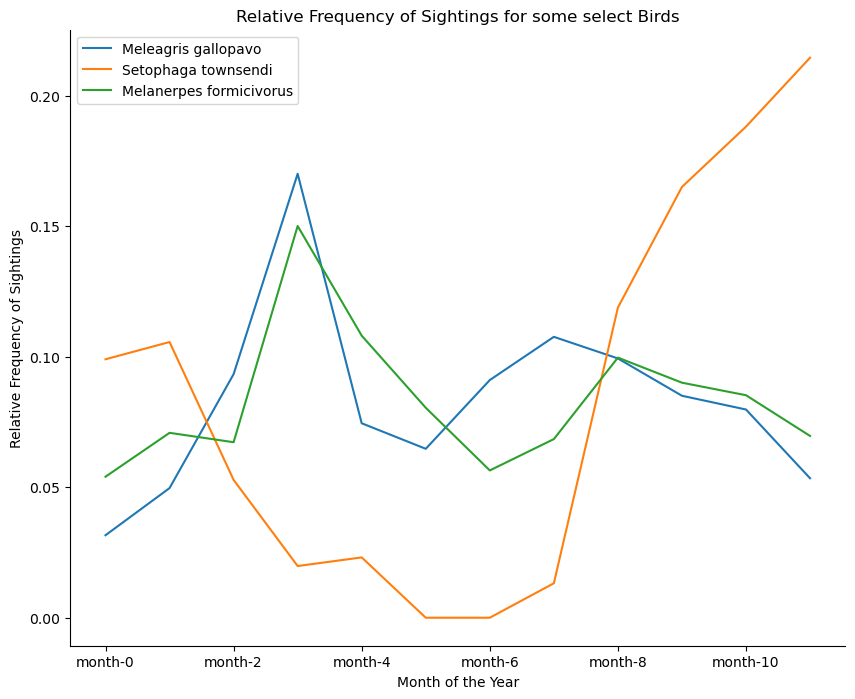

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
df_full_final.T.loc[[f"month-{x}" for x in range(12)], [0,1,2]].plot(ax=ax)
plt.legend(['Meleagris gallopavo',
'Setophaga townsendi',
'Melanerpes formicivorus'])
plt.title("Relative Frequency of Sightings for some select Birds")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Month of the Year")
ax.set_ylabel("Relative Frequency of Sightings")
plt.show()

In [21]:
pca = PCA(n_components=12)

In [22]:
pca.fit(df_full_final[[f"month-{x}" for x in range(12)]])

PCA(n_components=12)

In [23]:
pca.components_

array([[-0.35573337, -0.20986457, -0.14651709,  0.32215211,  0.3638388 ,
         0.37216271,  0.27346115,  0.21639022,  0.07833495, -0.17139628,
        -0.35997586, -0.38285277],
       [-0.17257609, -0.13355367, -0.28602856, -0.42885556, -0.21925946,
        -0.14144298,  0.10355929,  0.51894009,  0.52696792,  0.20732324,
         0.10616067, -0.08123489],
       [ 0.16530847,  0.19732122,  0.4481487 ,  0.23184585, -0.16376432,
        -0.350537  , -0.28686603,  0.41612202,  0.15702244, -0.21379358,
        -0.40800121, -0.19280655],
       [-0.27990091, -0.10224606, -0.12165997,  0.6377801 , -0.10452158,
        -0.36101309, -0.15603106, -0.1820103 ,  0.16737919,  0.39168201,
         0.2826116 , -0.17206996],
       [ 0.21484012, -0.16056704, -0.52447498,  0.33544869, -0.00382753,
        -0.21838643,  0.04561393,  0.31275899, -0.14274271, -0.3509617 ,
        -0.00695877,  0.49925744],
       [ 0.07127275, -0.04504127,  0.14762307,  0.13810124, -0.62556386,
         0.011338  ,  

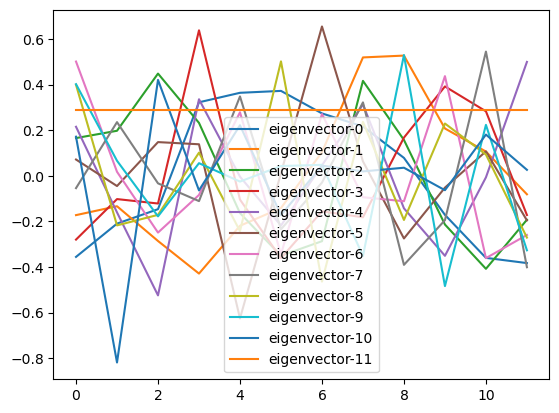

In [24]:
for x, eig in enumerate(pca.components_):
    plt.plot(eig, label=f'eigenvector-{x}')
plt.legend()

In [25]:
df_full_final

,Unnamed: 0,aviID_short,month-0,month-1,month-2,month-3,month-4,month-5,month-6,month-7,...,Migration,Trophic.Level,Trophic.Niche,Primary.Lifestyle,Min.Latitude,Max.Latitude,Centroid.Latitude,Centroid.Longitude,Range.Size,merge_ind
0,0,9C5ED06A,0.031603,0.049661,0.093303,0.170053,0.074492,0.064710,0.091046,0.107600,...,1.0,Herbivore,Omnivore,Terrestrial,16.91,50.63,37.44,-98.20,7259958.92,both
1,1,F6C6C3F7,0.099010,0.105611,0.052805,0.019802,0.023102,0.000000,0.000000,0.013201,...,3.0,Carnivore,Invertivore,Insessorial,42.15,66.71,55.15,-128.60,1406060.25,both
2,2,7E327303,0.054022,0.070828,0.067227,0.150060,0.108043,0.080432,0.056423,0.068427,...,1.0,Herbivore,Granivore,Insessorial,1.45,45.70,25.79,-104.16,1502706.45,both
3,3,EB98812F,0.076605,0.074534,0.086957,0.074534,0.049689,0.020704,0.082816,0.103520,...,3.0,Carnivore,Vertivore,Aerial,23.28,53.31,41.25,-100.49,8393137.06,both
4,4,56CCA717,0.190789,0.085526,0.059211,0.013158,0.013158,0.000000,0.000000,0.023026,...,3.0,Herbivore,Herbivore aquatic,Aquatic,38.65,75.28,59.60,26.95,28403500.77,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,134,E0A04985,0.000000,0.000000,0.000000,0.287805,0.346341,0.190244,0.126829,0.039024,...,3.0,Carnivore,Invertivore,Insessorial,19.50,47.60,34.01,-109.65,3499111.39,both
135,135,3F9E1C51,0.000000,0.000000,0.000000,0.060000,0.010000,0.010000,0.070000,0.510000,...,3.0,Carnivore,Aquatic predator,Aerial,24.14,33.83,31.85,-116.30,1309.31,both
136,136,E6F3BA54,0.000000,0.000000,0.000000,0.031746,0.079365,0.031746,0.010582,0.402116,...,3.0,Carnivore,Aquatic predator,Terrestrial,50.94,75.25,65.91,-35.96,9098836.74,both
137,137,F6CA75F0,0.000000,0.000000,0.000000,0.007692,0.300000,0.176923,0.161538,0.161538,...,3.0,Carnivore,Invertivore,Insessorial,7.31,67.81,45.91,-116.12,6939803.44,both


In [26]:
df_full_final2 = df_full_final.copy()

In [27]:
df_full_final2[[f"PC_Score-{x}" for x in range(12)]] = pca.transform(df_full_final[[f"month-{x}" for x in range(12)]])

In [28]:
df_full_final2

,Unnamed: 0,aviID_short,month-0,month-1,month-2,month-3,month-4,month-5,month-6,month-7,...,PC_Score-2,PC_Score-3,PC_Score-4,PC_Score-5,PC_Score-6,PC_Score-7,PC_Score-8,PC_Score-9,PC_Score-10,PC_Score-11
0,0,9C5ED06A,0.031603,0.049661,0.093303,0.170053,0.074492,0.064710,0.091046,0.107600,...,0.034480,0.056222,0.005527,0.021949,-0.013003,0.000680,-0.019106,-0.013235,0.000760,2.255141e-17
1,1,F6C6C3F7,0.099010,0.105611,0.052805,0.019802,0.023102,0.000000,0.000000,0.013201,...,-0.067698,0.038350,0.011335,-0.066079,-0.011502,-0.030912,-0.031771,-0.013028,-0.027580,9.714451e-17
2,2,7E327303,0.054022,0.070828,0.067227,0.150060,0.108043,0.080432,0.056423,0.068427,...,0.002288,0.042328,0.002770,-0.032897,0.000963,-0.000667,-0.008581,0.006312,-0.018876,-6.071532e-17
3,3,EB98812F,0.076605,0.074534,0.086957,0.074534,0.049689,0.020704,0.082816,0.103520,...,0.008570,0.002775,0.023009,0.010483,0.004446,0.004161,-0.039059,-0.030718,-0.000653,4.163336e-17
4,4,56CCA717,0.190789,0.085526,0.059211,0.013158,0.013158,0.000000,0.000000,0.023026,...,-0.046029,-0.047254,0.098672,-0.054174,0.013514,-0.068604,-0.013202,-0.033424,-0.000600,2.775558e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,134,E0A04985,0.000000,0.000000,0.000000,0.287805,0.346341,0.190244,0.126829,0.039024,...,-0.078181,0.028680,0.064047,-0.092299,0.046488,0.056821,-0.022497,0.010089,0.015195,-1.734723e-17
135,135,3F9E1C51,0.000000,0.000000,0.000000,0.060000,0.010000,0.010000,0.070000,0.510000,...,0.203664,-0.019306,0.119484,0.016953,-0.040741,0.085582,0.057724,-0.069832,0.005207,1.110223e-16
136,136,E6F3BA54,0.000000,0.000000,0.000000,0.031746,0.079365,0.031746,0.010582,0.402116,...,0.205412,-0.018137,0.052725,-0.129909,-0.047210,-0.018270,0.004452,0.062134,0.013122,2.428613e-17
137,137,F6CA75F0,0.000000,0.000000,0.000000,0.007692,0.300000,0.176923,0.161538,0.161538,...,-0.081240,-0.124236,-0.026463,-0.110018,0.074195,0.049496,-0.044210,-0.010422,0.028773,2.428613e-17


In [29]:
np.cumsum(pca.explained_variance_ratio_)

array([0.50232911, 0.71044239, 0.78168631, 0.84209733, 0.87999066,
       0.91055521, 0.93594387, 0.95629433, 0.97364998, 0.98930686,
       1.        , 1.        ])

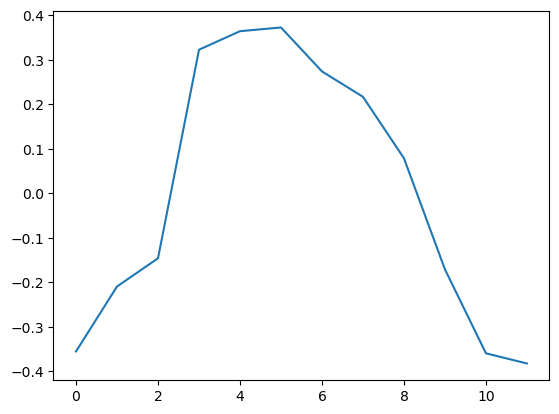

In [31]:
plt.plot(pca.components_[0])

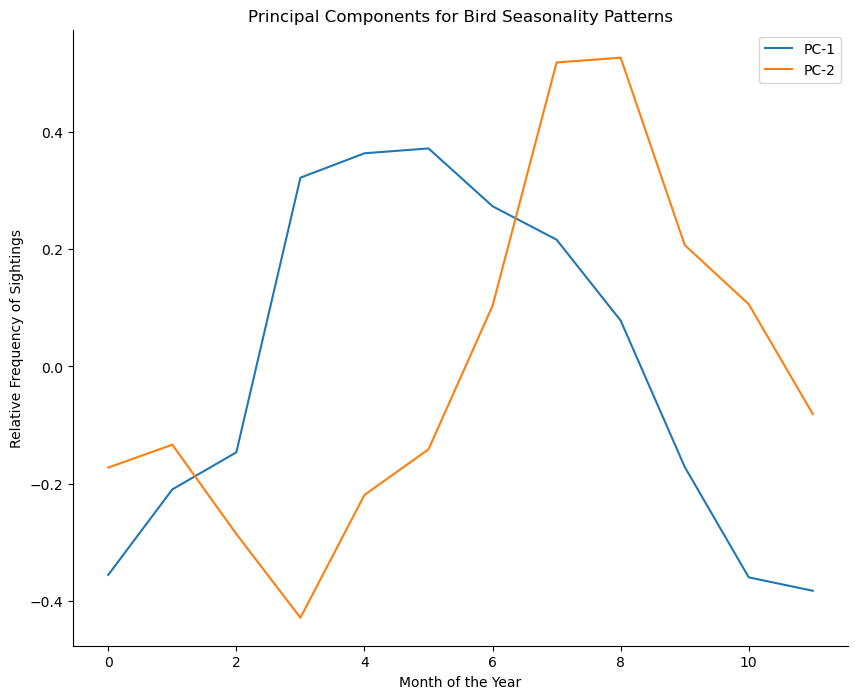

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.plot(pca.components_[0], label='PC-1')
plt.plot(pca.components_[1], label='PC-2')
# plt.plot(pca.components_[2], label='PC-3')
plt.legend()
plt.title("Principal Components for Bird Seasonality Patterns")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Month of the Year")
ax.set_ylabel("Relative Frequency of Sightings")
plt.show()

In [200]:
import skfda

In [203]:
dir(skfda.ml.regression)

['HistoricalLinearRegression',
 'KNeighborsRegressor',
 'KernelRegression',
 'LinearRegression',
 'RadiusNeighborsRegressor']

In [204]:
skfda.__version__

'0.8.1'

In [205]:
import fdasrsf as fs